This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data). The synthesis model is a CART. The model used for the KS-statistic calculation is also a CART.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import preprocessing

from scipy.stats import ks_2samp

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

Steps for CART estimation of pmse ratio.

* calculate the pMSE between pairs of synthetic data sets generated from the same original data
* the pairs can be used to estimate the expected pMSE even when the synthesizing model is incorrect since both data are drawn from the same distribution
* for most large complex data sets, synthesized by CART models, the expected pMSE from pairs will be close to, or slightly lower than the null pMSE

In [2]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [3]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/cleaned_data.csv")

***

# Full Sequential Synthesis Driven by Bayesian Optimization

Function to be used in Bayesian bootstrap.

In [4]:
def stat(x):
    return x

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [5]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_sex_,
                 mb_age_,
                 mb_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,["latitude", "longitude"]], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,["latitude", "longitude"]]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,["latitude", "longitude"]])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(bst_vals[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ####################################################################################################
        
    ########### Code for age CART ##########
    cart_age = DecisionTreeClassifier(min_samples_leaf=mb_age_, random_state=rng)
    
    cart_age.fit(X=train_data.loc[:,["latitude", "longitude", "sex"]], y=train_data.loc[:,"age"])
    
    node_indicators = cart_age.decision_path(train_data.loc[:,["latitude", "longitude", "sex"]]).toarray()
    
    node_outcomes = [train_data.age[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_age.apply(sXs[i].loc[:,["latitude", "longitude", "sex"]])
        
        new_age = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_age[synth_leaves==x] = rng.choice(bst_vals[x], size=np.sum(synth_leaves==x))
        
        new_age = pd.Series(new_age)
        
        new_age.name = "age"
        
        sXs[i] = pd.concat([sXs[i], new_age], axis=1)
        
    ####################################################################################################
    
    ########### Code for state CART ##########
    
    cart_state = DecisionTreeClassifier(min_samples_leaf=mb_state_, random_state=rng)
    
    cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])
    
    node_indicators = cart_state.decision_path(train_data.loc[:,["latitude", "longitude", "sex", "age"]]).toarray()
    
    node_outcomes = [train_data.state[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_state.apply(sXs[i].loc[:,["latitude", "longitude", "sex", "age"]])
        
        new_state = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_state[synth_leaves==x] = rng.choice(bst_vals[x], size=np.sum(synth_leaves==x))
        
        new_state = pd.Series(new_state)
        
        new_state.name = "state"
        
        sXs[i] = pd.concat([sXs[i], new_state], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM, cart_sex, cart_age, cart_state

In [6]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_sex_, mb_age_, mb_state_):

        pmse_ratios, _, _, _, _, _ = train_models(train_data=train_data,
                                                  number_synthetic_datasets=number_synthetic_datasets,
                                                  number_gmm_initializations=number_gmm_initializations,
                                                  num_components_=int(num_components_),
                                                  mb_sex_=int(mb_sex_),
                                                  mb_age_=int(mb_age_),
                                                  mb_state_=int(mb_state_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "mb_sex_": (2, 300.99),
            "mb_age_": (2, 300.99),
            "mb_state_": (2, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-2)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [7]:
nsd = 20
ngi = 5
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [8]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------
| 1         | -0.1596   | 59.26     | 188.0     | 132.9     | 672.0     |
| 2         | -0.3747   | 235.2     | 83.5      | 84.66     | 681.9     |
| 3         | -2.189    | 288.5     | 263.9     | 109.0     | 501.1     |
| 4         | -1.612    | 206.3     | 215.1     | 112.7     | 537.3     |
| 5         | -0.8074   | 152.4     | 6.117     | 233.1     | 730.5     |
| 6         | -1.006    | 87.27     | 128.1     | 65.66     | 735.1     |
| 7         | -0.7085   | 45.69     | 186.4     | 188.3     | 663.1     |
| 8         | -1.261    | 105.2     | 217.4     | 253.2     | 408.1     |
| 9         | -0.1533   | 241.1     | 76.29     | 90.11     | 675.2     |
| 10        | -0.6797   | 255.8     | 56.64     | 104.4     | 659.1     |
| 11        | -0.3564   | 75.0      | 182.7     | 138.4     | 654.9     |
| 12        | -0.1275   | 54.4      | 

| 1         | -0.95     | 156.4     | 97.74     | 52.27     | 231.5     |
| 2         | -0.348    | 280.5     | 19.61     | 132.3     | 214.9     |
| 3         | -1.514    | 149.0     | 211.7     | 232.8     | 441.7     |
| 4         | -0.6446   | 277.0     | 164.7     | 207.4     | 348.1     |
| 5         | -0.7313   | 75.01     | 170.5     | 81.52     | 341.4     |
| 6         | -1.435    | 179.3     | 6.656     | 106.6     | 409.4     |
| 7         | -0.9335   | 268.5     | 169.3     | 209.2     | 345.9     |
| 8         | -0.4373   | 281.9     | 24.8      | 138.1     | 232.5     |
| 9         | -3.764    | 184.5     | 221.1     | 289.2     | 688.4     |
| 10        | -1.467    | 301.0     | 129.2     | 193.5     | 359.3     |
| 11        | -0.6205   | 272.0     | 173.4     | 218.4     | 349.8     |
| 12        | -0.6079   | 259.3     | 174.2     | 203.0     | 341.5     |
| 13        | -0.8607   | 296.3     | 30.41     | 136.3     | 216.4     |
| 14        | -1.553    | 294.4     | 

| 2         | -0.261    | 243.1     | 212.2     | 7.192     | 341.2     |
| 3         | -0.4832   | 61.93     | 149.8     | 90.78     | 749.8     |
| 4         | -0.3279   | 204.4     | 105.7     | 34.61     | 743.9     |
| 5         | -2.428    | 112.8     | 61.0      | 290.9     | 360.8     |
| 6         | -0.7923   | 147.4     | 124.0     | 57.57     | 746.2     |
| 7         | -0.238    | 266.4     | 85.84     | 9.464     | 741.1     |
| 8         | -0.04264  | 255.2     | 124.9     | 2.0       | 654.8     |
| 9         | -0.227    | 197.4     | 92.73     | 35.89     | 736.6     |
| 10        | -0.9514   | 218.0     | 41.42     | 9.352     | 660.4     |
| 11        | -0.2222   | 276.5     | 151.5     | 48.16     | 667.1     |
| 12        | -0.1335   | 262.8     | 174.0     | 2.0       | 616.6     |
| 13        | -0.2102   | 265.9     | 199.2     | 2.0       | 465.0     |
| 14        | -0.6801   | 206.4     | 278.9     | 2.0       | 432.8     |
| 15        | -0.7692   | 301.0     | 

***

In [9]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

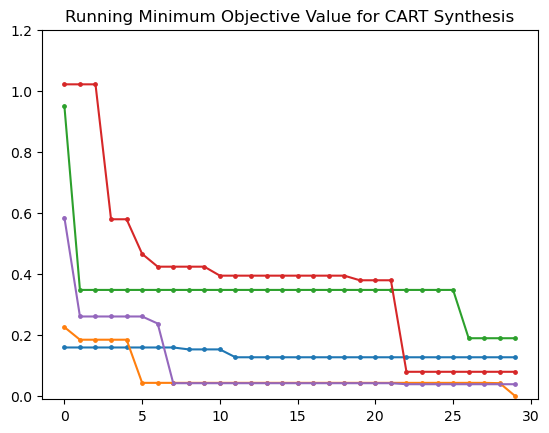

In [10]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.ylim(-0.01, 1.2)
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [11]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [12]:
best_params

{'target': -0.0002057322164208027,
 'params': {'mb_age_': 37.398670212331204,
  'mb_sex_': 156.67020150677124,
  'mb_state_': 25.4509644201019,
  'num_components_': 775.7703724051606}}

***

Generate 1000 synthetic datasets, choose the 20 that have the pMSE closest to 1.

In [13]:
pmse_ratios, full_sXs, GMM, cart_sex, cart_age, cart_state = train_models(train_data=train_data,
                                                                          number_synthetic_datasets=20,
                                                                          # hyperparameters for GMM
                                                                          number_gmm_initializations=ngi,
                                                                          num_components_=int(best_params['params']['num_components_']),
                                                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                                                          mb_age_=int(best_params['params']['mb_age_']),
                                                                          mb_state_=int(best_params['params']['mb_state_']))

In [14]:
np.mean(pmse_ratios)

0.9813835543699284

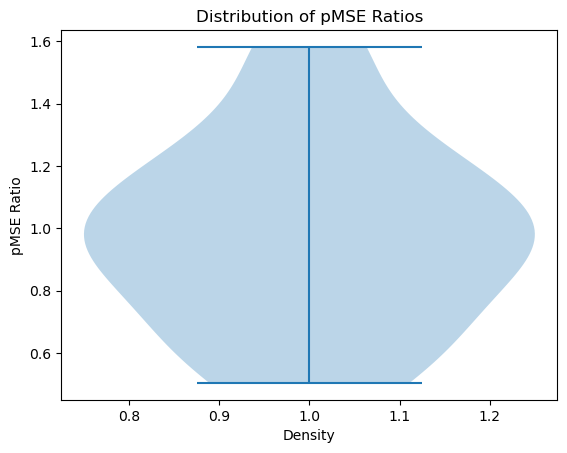

In [15]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [17]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/synthetic_datasets/full_cart_mb_logistic_pmse_" + str(i) + ".csv", index=False)

In [ ]:
full_sXs[0]

***

Produce inference reduced data sets.

In [ ]:
def inference_reduction(original_data, synthetic_data, mixture_model, deltas, c, prior_prob):
    
    # number of original records
    num_records = original_data.shape[0]
    
    # record percentages
    print_nums = [int(np.ceil(i*num_records)) for i in [0.25, 0.5, 0.75]]
    
    # random number generator
    rng = default_rng()
    
    # copy the synthetic dataset
    new_sX = synthetic_data
    
    # tree for synthetic locations
    sX_tree = cKDTree(new_sX[["latitude", "longitude"]])
    
    # store mixture component parameters
    mus = mixture_model.means_
    sigmas = mixture_model.covariances_
    
    # temporary count of the number of rows that violate one or more conditions
    violator_count = num_records
    
    # number of anonymization loops required
    num_loops = 1
    
    # while we have any violator rows
    while violator_count > 0:
        
        # reset violator count
        violator_count = 0
        
        # for each original record
        # we shuffle the records each time so that the violating records are fixed in a random order
        for i, original_record in original_data.sample(frac=1.0).reset_index(drop=True).iterrows():
            
            original_location = original_record.loc[["latitude", "longitude"]]
            original_categorical = original_record.loc[["sex", "age", "state"]]
            
            # for each delta
            for delta in deltas:
                    
                ##### Test the Inference Criterion
                
                # find synthetic neighbors based on location
                location_neighbors = sX_tree.query_ball_point(original_location, r=delta, p=2.0)
                
                # matches on categorical attributes from location neighbors
                categorical_matches = (new_sX.loc[location_neighbors,['sex', 'age']] == original_categorical[["sex", "age"]]).all(1)
                
                matching_rows = new_sX.loc[location_neighbors,:].loc[categorical_matches.values,:]
                
                # if there are any records in the location neighborhood that match on sex and age
                
                if matching_rows.shape[0] > 0:
                
                    if original_categorical['state'] == 1.0:
                        prior = prior_prob
                    else:
                        prior = 1-prior_prob
                        
                    num_matching = np.sum(matching_rows['state'] == original_categorical['state'])
            
                    cond = num_matching/matching_rows.shape[0] * 1/prior
                
                    if cond > c:
                        
                        # add one to number of violators
                        violator_count += 1
                        
                        # number of records with non-matching sensitive variable needed to meet inference
                        num_needed = int(np.ceil(num_matching/(prior*c) - matching_rows.shape[0]))
                        
                        # find the component with the highest responsibility for the confidential record
                        component_index = np.argmax(GMM.predict_proba(pd.DataFrame(original_location).T), axis = 1)[0]
                        current_mu = mus[component_index,:]
                        current_sigma = sigmas[component_index,:,:]
            
                        valid_candidates = np.zeros((0,2))
                        num_candidate_loops = 0
                        while valid_candidates.shape[0] < num_needed:
                        
                            # add a very small number to the diagonal of the covariance matrix to increase
                            # the likelihood of sampling candidate points - do this proportionally to the number
                            # of times this loop has executed
                            # np.fill_diagonal(current_sigma, np.diag(current_sigma) + num_candidate_loops*1e-6)
                        
                            # generate a bunch of candidate points
                            candidate_points = rng.multivariate_normal(current_mu, current_sigma, size=100000)
                            candidate_tree = cKDTree(candidate_points)
                            valid_indices = candidate_tree.query_ball_point(original_location, delta, p=2.0, return_sorted=True)
                            valid_candidates = np.vstack([valid_candidates, candidate_points[valid_indices,:]])
                            num_candidate_loops += 1
                            if num_candidate_loops > 100:
                                print('Stuck in inference loop.')
                            
                        # print(num_candidate_loops)
                    
                        # select the number of needed candidates
                        new_locations = valid_candidates[:num_needed,:]
                    
                        new_categorical = np.vstack([np.array(original_categorical).reshape(1,-1) for k in range(num_needed)])
                    
                        new_records = pd.DataFrame(np.hstack([new_locations, new_categorical]))
                    
                        new_records.columns = new_sX.columns
                        
                        new_records['state'] = 1.0 - original_categorical['state']
                    
                        new_sX = pd.concat([new_sX, new_records], axis=0).reset_index(drop=True)
                    
                        # rebuild the tree for synthetic locations
                        sX_tree = cKDTree(new_sX[["latitude", "longitude"]])
                    
#                     # put in a break statement - if we executed the previous code conditional on the if statement,
#                     # we know the linkability criterion is satisfied for all larger delta values for this record
#                     break
    
            if int(i) in print_nums:
                print("Record " + str(i) + " completed.")
                
        print("Full anonymization loop " + str(num_loops) + " completed.")
        
        num_loops += 1
                    
    return new_sX

In [ ]:
prior_death_prob = 152/9583
delta_vals = np.linspace(0.00001, 1.0, 20)
c=10

In [ ]:
inference_sXs = [inference_reduction(train_data, X, GMM, delta_vals, c, prior_death_prob) for X in full_sXs]

In [ ]:
[x.shape for x in inference_sXs]

In [ ]:
train_data.shape

In [ ]:
for i, sX in enumerate(inference_sXs):
    sX.to_csv("Data/synthetic_datasets/cart_mb_inf_logistic_pmse_" + str(i) + ".csv", index=False)